In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
#%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.patches import Patch
from matplotlib.offsetbox import AnchoredText
import pandas as pd
import numpy as np
from Color import *
from operator import truediv, sub
from matplotlib.lines import Line2D
from matplotlib.ticker import FormatStrFormatter

# Matplotlib font configuration
from MatplotlibFonts import *

# Helpers
from BrokenPlot import *

# Change the font size
rcParams.update({"font.size": 13})

In [36]:
%reload_ext autoreload
from BenchmarkConfiguration import *
from Color import *

In [16]:
RESULT_DIR='../benchmarks/logs/'

In [17]:
Benchmarks = [
    'coremark',
    'picojpeg',
    'aes',
    'crc',
    'dijkstra',
    'sha',
]

BaseConfigurations = [
    'nacho_naive',
    'nacho_pw',
    'nacho_stcont',
    'nacho_pw_st',
    'nacho_pw_stcont',
    'nacho_clank',
    'prowl',
    'clank',
    'plain_c'
]

CacheConfigurations = [
    'None',
    '256-2',
    '256-4',
    '512-2',
    '512-4',
    '1024-2',
    '1024-4'
]

In [18]:
# Load all the results into a dictionary

def loadResult(Results, benchmark, config, cache, postfix='-0-0-final'):
    if cache == '0-0':
        filename = RESULT_DIR + '/' + benchmark + '-uninstrumented-run-' + config + postfix
    else:
        filename = RESULT_DIR + '/' + benchmark + '-uninstrumented-run-' + config + '-' + cache + postfix
    
    if config not in Results[benchmark]:
        Results[benchmark][config] = {}
    
    # Add the results
    Results[benchmark][config][cache] = dict(pd.read_csv(filename, delimiter=":", header = None).values)

Results = {}

for benchmark in Benchmarks:
    Results[benchmark] = {}

    # Load Nacho results
    nacho_caches = [
        '256-2',
        #'256-4',
        '512-2',
        #'512-4',
        #'1024-2',
        #'1024-4'
    ]
    for cache in nacho_caches:
        loadResult(Results, benchmark, 'nacho_naive', cache)
        loadResult(Results, benchmark, 'nacho_pw', cache)
        loadResult(Results, benchmark, 'nacho_stcont', cache)
        loadResult(Results, benchmark, 'nacho_pw_st', cache)
        loadResult(Results, benchmark, 'nacho_pw_stcont', cache)
        loadResult(Results, benchmark, 'nacho_clank', cache)

    # Load Prowl results
    prowl_caches = [
        '256-2',
        '512-2',
        #'1024-2',
    ]
    for cache in prowl_caches:
        loadResult(Results, benchmark, 'prowl', cache)

    # Load Clank results
    loadResult(Results, benchmark, 'clank', '0-0')

    # Load plain C results
    loadResult(Results, benchmark, 'plain_c', '0-0', '-final')
    
#Results

# Execution Time

In [37]:
# Benchmark plots with execution time
# Plot each benchmark, each config, two cache configs (256, 512)

PlotBenchmarks = Benchmarks
PlotConfigurations = BaseConfigurations

EntryToPlot='cycles'

def getPlotData(PlotData, benchmark, config, cache):
    key = config+'-'+cache
    if key not in PlotData[benchmark]:
        PlotData[benchmark][key] = {}
        
    PlotData[benchmark][config+'-'+cache] = Results[benchmark][config][cache][EntryToPlot]

PlotData = {}
for benchmark in PlotBenchmarks:
    PlotData[benchmark] = {}
    getPlotData(PlotData, benchmark, 'plain_c', '0-0')
    
    getPlotData(PlotData, benchmark, 'clank', '0-0')
    
    getPlotData(PlotData, benchmark, 'prowl', '256-2')
    getPlotData(PlotData, benchmark, 'nacho_pw_stcont', '256-2')
    getPlotData(PlotData, benchmark, 'nacho_clank', '256-2')
    
    getPlotData(PlotData, benchmark, 'prowl', '512-2')
    getPlotData(PlotData, benchmark, 'nacho_pw_stcont', '512-2')
    getPlotData(PlotData, benchmark, 'nacho_clank', '512-2')
    
    
#PlotData
PlotDataDF = pd.DataFrame.from_dict(PlotData)

In [38]:
# Remove the "base" cost of plain-c
#dfb = PlotDataDF.copy()

#base_cost_config = 'plain_c-0-0'

#for benchmark in Benchmarks:
#    base_cost_value = dfb[benchmark][base_cost_config]
#    dfb[benchmark] = dfb[benchmark]-base_cost_value

# Remove the plain_c entry
#dfb = dfb.drop('plain_c-0-0')

In [39]:
# Normalize
dfn = PlotDataDF.copy()

norm_config = 'plain_c-0-0'

for benchmark in Benchmarks:
    norm_value = dfn[benchmark][norm_config]
    dfn[benchmark] = dfn[benchmark]/norm_value

dfn = dfn.drop('plain_c-0-0')

# Rename
dfn = dfn.rename(columns=BenchmarkNameMap)
dfn

,CoreMark,picojpeg,Tiny AES,CRC,Dijkstra,SHA
clank-0-0,16.332660,29.009249,19.581977,7.582297,4.267591,2.693548
prowl-256-2,9.097784,9.753692,3.594685,2.390323,3.091138,4.561267
nacho_pw_stcont-256-2,2.650609,3.013914,1.560528,1.538907,2.784291,2.097668
nacho_clank-256-2,2.404317,2.852037,1.424653,1.451237,2.738345,2.097618
prowl-512-2,5.472520,4.472606,1.894600,1.997280,2.744210,3.662976
nacho_pw_stcont-512-2,1.216135,2.502428,1.274745,1.298105,2.582984,1.516276
nacho_clank-512-2,1.195694,2.425176,1.250054,1.294181,2.557688,1.516518


In [54]:
# Colors
color_list = []
for config in dfn.T:
    stripped_config = config.split('-')[0]
    color_list += [ColorScheme[stripped_config]]
    
color_list

['#464B75', '#ee7733', '#81b29a', '#F1C40F', '#ee7733', '#81b29a', '#F1C40F']

In [55]:
# Hatches
cache_256_hatch = '///'
cache_512_hatch = '...'

hatches_list = []
for config in dfn.T:
    cache_size = config.split('-')[1]
    hatch = ''
    
    if cache_size == '256':
        hatch = cache_256_hatch
    elif cache_size == '512':
        hatch = cache_512_hatch

    hatches_list += [hatch]

hatches_list

['', '///', '///', '///', '...', '...', '...']

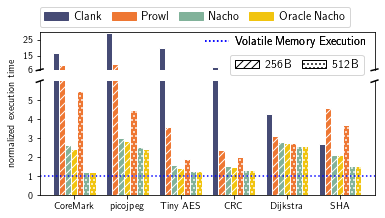

In [56]:

# Execution time plot
fig, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6, 3), gridspec_kw={'height_ratios': [1, 3]})
ax.set_ylim(6, 30)
ax2.set_ylim(0, 6)

configureBrokenPlot(ax, ax2)

dfn.T.plot(kind='bar', ax=ax, legend=None, width=0.8, color=color_list, edgecolor='white', linewidth=1)
dfn.T.plot(kind='bar', ax=ax2, legend=None, width=0.8, color=color_list, edgecolor='white', linewidth=1)

applyHatches(Benchmarks, hatches_list, ax)
applyHatches(Benchmarks, hatches_list, ax2)
     
# Line at 1 (norm)
# Average for Ratchet and Opt-All
plain_c_line = ax2.axhline(y = 1.0, color = 'blue', linestyle = ':', label='Volatile Memory Execution', linewidth=1.5)

#
# Add custom legend (manual way)
#
 
# Config legend
configs = ['Clank', 'Prowl','Nacho', 'Oracle Nacho']
config_colors = [ColorScheme['clank'], ColorScheme['prowl'], ColorScheme['nacho_pw_stcont'], ColorScheme['nacho_clank']]

legends = []

handles = []
for idx, l in enumerate(configs):
    handles.append(Patch(label=l, color=config_colors[idx]))
legend_configs = plt.legend(handles=handles, loc='lower left', ncol=4, bbox_to_anchor = (-0.018, 1.42), 
                            fancybox=True, fontsize=12, columnspacing=0.8, handletextpad=0.5);
ax2.add_artist(legend_configs)

# Cache legends
caches = ['256\\,B', '512\\,B']
config_hatches = [cache_256_hatch, cache_512_hatch]

# Config legend

handles = []
for idx, l in enumerate(caches):
    handles.append(Patch(label=l, hatch=config_hatches[idx], facecolor='none', edgecolor='black'))
cache_configs = plt.legend(handles=handles, loc='lower left', ncol=2, bbox_to_anchor = (0.55, 1), 
                           fancybox=True, fontsize=12, columnspacing=0.8, handletextpad=0.5);
ax2.add_artist(cache_configs)
legends.append(cache_configs)

# Normalized Plain C legend
handles = []
handles.append(plain_c_line)
cache_configs = plt.legend(handles=handles, loc='lower left', ncol=1, bbox_to_anchor = (0.46, 1.2), 
                           fancybox=True, frameon=False, fontsize=12, columnspacing=0.8, handletextpad=0.5);
ax2.add_artist(cache_configs)
legends.append(cache_configs)

# Plotting
#ax.set_ylabel("normalized execution time")
fig.text(0.06, 0.5, 'normalized execution time', ha='center', va='center', rotation='vertical')

ax.set_yticks([6, 15, 25])
ax2.set_yticks([0, 1, 2, 3, 4, 5])

plt.subplots_adjust(hspace=0.15)

plt.xticks(rotation=0)
#plt.tight_layout()
plt.show()

In [57]:
# Save the figure
ax2.get_figure().savefig('plots/benchmark-execution-time.pdf', bbox_inches='tight')

# Checkpoints

In [58]:
# Checkpoint plot

PlotBenchmarks = Benchmarks
PlotConfigurations = BaseConfigurations

EntryToPlot='checkpoint'

def getPlotData(PlotData, benchmark, config, cache):
    key = config+'-'+cache
    if key not in PlotData[benchmark]:
        PlotData[benchmark][key] = {}
        
    PlotData[benchmark][config+'-'+cache] = Results[benchmark][config][cache][EntryToPlot]
    
PlotData = {}
for benchmark in PlotBenchmarks:
    PlotData[benchmark] = {}
    
    getPlotData(PlotData, benchmark, 'clank', '0-0')
    
    getPlotData(PlotData, benchmark, 'prowl', '256-2')
    getPlotData(PlotData, benchmark, 'prowl', '512-2')
    
    getPlotData(PlotData, benchmark, 'nacho_pw_stcont', '256-2')
    getPlotData(PlotData, benchmark, 'nacho_pw_stcont', '512-2')
    
    getPlotData(PlotData, benchmark, 'nacho_clank', '256-2')
    getPlotData(PlotData, benchmark, 'nacho_clank', '512-2')
    
    
#PlotData
PlotDataDF = pd.DataFrame.from_dict(PlotData)


In [59]:
# Normalize
dfn = PlotDataDF.copy()

norm_config = 'clank-0-0'

for benchmark in PlotBenchmarks:
    norm_value = dfn[benchmark][norm_config]
    dfn[benchmark] = dfn[benchmark]/norm_value

# Rename
dfn = dfn.rename(columns=BenchmarkNameMap)
dfn

,CoreMark,picojpeg,Tiny AES,CRC,Dijkstra,SHA
clank-0-0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
prowl-256-2,0.355575,0.223327,0.083070,0.134328,0.236156,4.028056
prowl-512-2,0.185700,0.081677,0.012662,0.082090,0.155555,2.267767
nacho_pw_stcont-256-2,0.062255,0.058348,0.015079,0.041045,0.361038,0.758329
nacho_pw_stcont-512-2,0.004756,0.044694,0.005588,0.014925,0.272553,0.255286
nacho_clank-256-2,0.050366,0.053742,0.008750,0.029851,0.339892,0.758226
nacho_clank-512-2,0.003874,0.042360,0.004656,0.014925,0.261998,0.255286


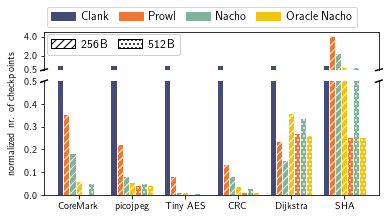

In [60]:
# Checkpoint plot

# Two plots for broken Y axis
fig, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6, 3), gridspec_kw={'height_ratios': [1, 3]})
ax.set_ylim(0.5, 4.5)
ax2.set_ylim(0, 0.5)

configureBrokenPlot(ax, ax2)

bottom = dfn.T.plot(ax=ax2, kind='bar', legend=None, width=0.8, color=color_list, edgecolor='white', linewidth=1)
top = dfn.T.plot(ax=ax, logy=False, kind='bar', legend=None, width=0.8, color=color_list, edgecolor='white', linewidth=1)

applyHatches(Benchmarks, hatches_list, ax)
applyHatches(Benchmarks, hatches_list, ax2)

#
# Add custom legend (manual way)
#
 
# Config legend
configs = ['Clank', 'Prowl','Nacho', 'Oracle Nacho']
config_colors = [ColorScheme['clank'], ColorScheme['prowl'], ColorScheme['nacho_pw_stcont'], ColorScheme['nacho_clank']]

handles = []
for idx, l in enumerate(configs):
    handles.append(Patch(label=l, color=config_colors[idx]))
legend_configs = plt.legend(handles=handles, loc='lower left', ncol=4, bbox_to_anchor = (-0.01, 1.42), 
                            fancybox=True, fontsize=12, columnspacing=0.8, handletextpad=0.5);
ax2.add_artist(legend_configs)

# Cache legends
caches = ['256\\,B', '512\\,B']
config_hatches = [cache_256_hatch, cache_512_hatch]

# Config legend
handles = []
for idx, l in enumerate(caches):
    handles.append(Patch(label=l, hatch=config_hatches[idx], facecolor='none', edgecolor='black'))
cache_configs = plt.legend(handles=handles, loc='lower left', ncol=2, bbox_to_anchor = (-0.01, 1.18), 
                           fancybox=True, fontsize=12, columnspacing=0.8, handletextpad=0.5);
ax2.add_artist(cache_configs)

# Plotting
fig.text(0.05, 0.5, 'normalized nr. of checkpoints', ha='center', va='center', rotation='vertical')

ax.set_yticks([0.5, 2 ,4])


plt.xticks(rotation=0)
plt.subplots_adjust(hspace=0.15)
plt.show()

In [61]:
# Save the figure
ax2.get_figure().savefig('plots/benchmark-checkpoints.pdf', bbox_inches='tight')

# Volatile (Cache) Accesses

In [62]:
cache_size = '512-2'
Entries = [
    'cache_read',
    'cache_write',
    'cache_cuckoo',
    'cache_checkpoint'
]

PlotBenchmarks = Benchmarks
PlotConfigurations = [
    'prowl',
    'nacho_pw_stcont',
    'nacho_clank',
]

NormConfig = 'nacho_pw_stcont'

# Normalize per benchmark to nacho_clank total number
NormValue = {}
for benchmark in Benchmarks:
    NormValue[benchmark] = 0
    for entry in Entries:
        NormValue[benchmark] += Results[benchmark][NormConfig][cache_size][entry]

def getPlotData(PlotData, entry, benchmark, config, cache):
    if config not in PlotData[entry][benchmark]:
        PlotData[entry][benchmark][config] = {}
    PlotData[entry][benchmark][config] = Results[benchmark][config][cache][entry] / NormValue[benchmark]


PlotData = {}
for entry in Entries:
    PlotData[entry] = {}
    
    for benchmark in PlotBenchmarks:
        PlotData[entry][benchmark] = {}
        
        #getPlotData(PlotData, entry, benchmark, 'clank', '0-0')
        getPlotData(PlotData, entry, benchmark, 'prowl', cache_size)
        getPlotData(PlotData, entry, benchmark, 'nacho_pw_stcont', cache_size)
        getPlotData(PlotData, entry, benchmark, 'nacho_clank', cache_size)
    
#PlotData
PlotDataDF = {}
for entry in Entries:
    PlotDataDF[entry] = pd.DataFrame.from_dict(PlotData[entry]).rename(columns=BenchmarkNameMap)

print('cache_read')
print(PlotDataDF['cache_read'])

print('cache_write')
print(PlotDataDF['cache_write'])

print('cache_checkpoint')
print(PlotDataDF['cache_checkpoint'])

print('cache_cuckoo')
print(PlotDataDF['cache_cuckoo'])

cache_read
                 CoreMark  picojpeg  Tiny AES       CRC  Dijkstra       SHA
prowl            0.679896  0.544985  0.690317  0.466863  0.527145  0.694110
nacho_pw_stcont  0.588902  0.507093  0.525302  0.451460  0.525070  0.664694
nacho_clank      0.588902  0.507093  0.525302  0.451460  0.525070  0.664694
cache_write
                 CoreMark  picojpeg  Tiny AES       CRC  Dijkstra       SHA
prowl            0.716419  0.526826  0.654289  0.512789  0.466306  0.441734
nacho_pw_stcont  0.388894  0.453000  0.432626  0.465247  0.457768  0.270946
nacho_clank      0.388894  0.453000  0.432626  0.465247  0.457768  0.270946
cache_checkpoint
                 CoreMark  picojpeg  Tiny AES       CRC  Dijkstra       SHA
prowl            0.161452  0.128793  0.059333  0.152135  0.013091  0.200509
nacho_pw_stcont  0.022203  0.039907  0.042072  0.083294  0.017162  0.064360
nacho_clank      0.020301  0.036318  0.038197  0.080251  0.016187  0.064354
cache_cuckoo
                 CoreMark  picojpeg

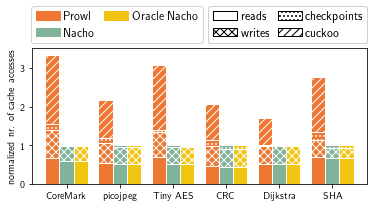

In [63]:
BarStack = [
    'cache_read',
    'cache_write',
    'cache_checkpoint',
    'cache_cuckoo'
]

HatchMap = {
    'cache_read': '',
    'cache_write': 'xxx',
    'cache_checkpoint': '...',
    'cache_cuckoo': '///'
}

# Colors
color_list = []
for config in PlotConfigurations:
    color_list += [ColorScheme[config]]
    
fig = plt.figure(figsize=(6, 2.5))
ax = fig.add_subplot(111)

def patchwork(ax, hatch):
    for bar in ax.patches:
        if bar.get_hatch() == None: 
            bar.set_hatch(hatch)

def plot_bar(N):
    D = PlotDataDF[BarStack[0]]
    for n in range(1, N+1):
        D = D + PlotDataDF[BarStack[n]]
        
    #D.T.plot(kind='bar', ax=ax2, width=0.8, color=color_list, edgecolor='white', legend=None, linewidth=1)
    D.T.plot(kind='bar', ax=ax, width=0.8, color=color_list, edgecolor='white', legend=None, linewidth=1)

    #patchwork(ax2, HatchMap[BarStack[N]])
    patchwork(ax, HatchMap[BarStack[N]])


# Plot the overlapping bars
plot_bar(3)
plot_bar(2)
plot_bar(1)
plot_bar(0)

# Custom legend
configs = ['Prowl','Nacho', 'Oracle Nacho']
config_colors = [ColorScheme['prowl'], ColorScheme['nacho_pw_stcont'], ColorScheme['nacho_clank']]

handles = []
for idx, l in enumerate(configs):
    handles.append(Patch(label=l, color=config_colors[idx]))
    
legend_configs = plt.legend(handles=handles, loc='lower left', ncol=2, bbox_to_anchor = (-0.02, 0.99), 
                            fancybox=True, fontsize=12, columnspacing=0.8, handletextpad=0.3);
ax.add_artist(legend_configs)

handles = []
hlw=1
handles.append(Patch(label='reads', hatch=HatchMap['cache_read'],
                     facecolor='none', edgecolor='black', linewidth=hlw))
handles.append(Patch(label='writes', hatch=HatchMap['cache_write'],
                     facecolor='none', edgecolor='black', linewidth=hlw))
handles.append(Patch(label='checkpoints', hatch=HatchMap['cache_checkpoint'],
                     facecolor='none', edgecolor='black', linewidth=hlw))
handles.append(Patch(label='cuckoo', hatch=HatchMap['cache_cuckoo'],
                     facecolor='none', edgecolor='black', linewidth=hlw))

legend_configs = plt.legend(handles=handles, loc='lower left', ncol=2, bbox_to_anchor = (0.508, 0.99), 
                            fancybox=True, fontsize=12, columnspacing=0.7, handletextpad=0.3);
ax.add_artist(legend_configs)



# Show the plot
plt.xticks(rotation=0)
#plt.tight_layout()

#fig.text(-0.01, 0.5, 'normalized nr. of cache accesses', ha='center', va='center', rotation='vertical')
ax.set_ylabel('normalized nr. of cache accesses')

#ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

ax.set_yticks([0, 1, 2, 3])
#ax2.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0,])
plt.show()

In [64]:
# Save the figure
ax.get_figure().savefig('plots/benchmark-volatile-accesses.pdf', bbox_inches='tight')

# NVM Access

In [78]:
# Checkpoint plot
cache_size = '512-2'
Entries = [
    'nvm_writes',
    'nvm_reads',
]

PlotBenchmarks = Benchmarks
PlotConfigurations = [
    'clank',
    'prowl',
    'nacho_pw_stcont',
    'nacho_clank',
]


NormConfig = 'clank'

# Normalize per benchmark to nacho_clank total number
NormValue = {}
for benchmark in Benchmarks:
    NormValue[benchmark] = 0
    for entry in Entries:
        NormValue[benchmark] += Results[benchmark][NormConfig]['0-0'][entry]

def getPlotData(PlotData, entry, benchmark, config, cache):
    if config not in PlotData[entry][benchmark]:
        PlotData[entry][benchmark][config] = {}
    PlotData[entry][benchmark][config] = Results[benchmark][config][cache][entry] / NormValue[benchmark]


PlotData = {}
for entry in Entries:
    PlotData[entry] = {}
    
    for benchmark in PlotBenchmarks:
        PlotData[entry][benchmark] = {}
        
        getPlotData(PlotData, entry, benchmark, 'clank', '0-0')
        getPlotData(PlotData, entry, benchmark, 'prowl', cache_size)
        getPlotData(PlotData, entry, benchmark, 'nacho_pw_stcont', cache_size)
        getPlotData(PlotData, entry, benchmark, 'nacho_clank', cache_size)
    
#PlotData
PlotDataDF = {}
for entry in Entries:
    PlotDataDF[entry] = pd.DataFrame.from_dict(PlotData[entry]).rename(columns=BenchmarkNameMap)


PlotDataDF['nvm_writes']

,CoreMark,picojpeg,Tiny AES,CRC,Dijkstra,SHA
clank,0.643401,0.656200,0.658413,0.653906,0.462458,0.364356
prowl,0.145462,0.067976,0.013352,0.078909,0.074058,0.758185
nacho_pw_stcont,0.007071,0.032922,0.007155,0.024145,0.119070,0.159952
nacho_clank,0.006213,0.031134,0.006265,0.023875,0.114556,0.160109


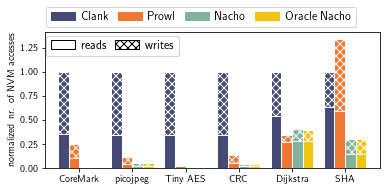

In [79]:
BarStack = [
    'nvm_reads',
    'nvm_writes',
]

HatchMap = {
    'nvm_reads': '',
    'nvm_writes': 'xxx',
}

# Colors
color_list = []
for config in PlotConfigurations:
    color_list += [ColorScheme[config]]
    
#fig, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6, 4), gridspec_kw={'height_ratios': [1, 2.5]})
ax = plt.figure(figsize=(6, 2.5)).add_subplot(111)

def patchwork(ax, hatch):
    for bar in ax.patches:
        if bar.get_hatch() == None: 
            bar.set_hatch(hatch)

def plot_bar(N):
    D = PlotDataDF[BarStack[0]]
    for n in range(1, N+1):
        D = D + PlotDataDF[BarStack[n]]
        
    D.T.plot(kind='bar', ax=ax, width=0.8, color=color_list, edgecolor='white', legend=None, linewidth=1)
    patchwork(ax, HatchMap[BarStack[N]])


# Plot the overlapping bars
plot_bar(1)
plot_bar(0)

# Custom legend
configs = ['Clank','Prowl','Nacho', 'Oracle Nacho']
config_colors = [ColorScheme['clank'], ColorScheme['prowl'], ColorScheme['nacho_pw_stcont'], ColorScheme['nacho_clank']]

handles = []
for idx, l in enumerate(configs):
    handles.append(Patch(label=l, color=config_colors[idx]))
legend_configs = plt.legend(handles=handles, loc='lower left', ncol=4, bbox_to_anchor = (-0.015, 0.99), 
                            fancybox=True, fontsize=12, columnspacing=0.8, handletextpad=0.5);
ax.add_artist(legend_configs)

handles = []
hlw=1
handles.append(Patch(label='reads', hatch=HatchMap['nvm_reads'],
                     facecolor='none', edgecolor='black', linewidth=hlw))
handles.append(Patch(label='writes', hatch=HatchMap['nvm_writes'],
                     facecolor='none', edgecolor='black', linewidth=hlw))

legend_configs = plt.legend(handles=handles, loc='lower left', ncol=2, bbox_to_anchor = (-0.015, 0.78), 
                            fancybox=True, fontsize=12, columnspacing=0.8, handletextpad=0.5);
ax.add_artist(legend_configs)

# Show the plot
plt.xticks(rotation=0)
#plt.tight_layout(pad=0.3)

#ax.set_ylim(0,0.2)

ax.set_ylabel("normalized nr. of NVM accesses")

#ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

plt.show()

In [81]:
# Save the figure
ax.get_figure().savefig('plots/benchmark-non-volatile-accesses.pdf', bbox_inches='tight')

In [80]:
PlotDataDF['nvm_writes'].T.add_suffix('_nvm_writes').T

,CoreMark,picojpeg,Tiny AES,CRC,Dijkstra,SHA
clank_nvm_writes,0.643401,0.656200,0.658413,0.653906,0.462458,0.364356
prowl_nvm_writes,0.145462,0.067976,0.013352,0.078909,0.074058,0.758185
nacho_pw_stcont_nvm_writes,0.007071,0.032922,0.007155,0.024145,0.119070,0.159952
nacho_clank_nvm_writes,0.006213,0.031134,0.006265,0.023875,0.114556,0.160109


In [68]:
dfRead = PlotDataDF['nvm_reads'].T.add_suffix('_nvm_reads').T
dfWrite = PlotDataDF['nvm_writes'].T.add_suffix('_nvm_writes').T

Order = ['clank', 'prowl', 'nacho_pw_stcont', 'nacho_clank']
Reindex = []
for o in Order:
    Reindex += [o+'_nvm_reads', o+'_nvm_writes']
#Reindex

MergedPlotDataDF = pd.concat([dfRead, dfWrite]).reindex(Reindex)
MergedPlotDataDF

,CoreMark,picojpeg,Tiny AES,CRC,Dijkstra,SHA
clank_nvm_reads,0.356599,0.343800,0.341587,0.346094,0.537542,0.635644
clank_nvm_writes,0.643401,0.656200,0.658413,0.653906,0.462458,0.364356
prowl_nvm_reads,0.104402,0.042555,0.019873,0.051257,0.267885,0.588915
prowl_nvm_writes,0.145462,0.067976,0.013352,0.078909,0.074058,0.758185
nacho_pw_stcont_nvm_reads,0.006073,0.020028,0.007278,0.019086,0.283396,0.142792
nacho_pw_stcont_nvm_writes,0.007071,0.032922,0.007155,0.024145,0.119070,0.159952
nacho_clank_nvm_reads,0.005636,0.019084,0.006817,0.018817,0.280870,0.142788
nacho_clank_nvm_writes,0.006213,0.031134,0.006265,0.023875,0.114556,0.160109


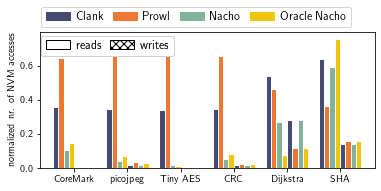

In [69]:
Bars = [
    'nvm_reads',
    'nvm_writes',
]

HatchMap = {
    'nvm_reads': '',
    'nvm_writes': 'xxx',
}

# Colors
color_list = []
for config in PlotConfigurations:
    color_list += [ColorScheme[config]]
    
#fig, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6, 4), gridspec_kw={'height_ratios': [1, 2.5]})
ax = plt.figure(figsize=(6, 2.5)).add_subplot(111)


MergedPlotDataDF.T.plot(kind='bar', ax=ax, width=0.8, color=color_list, edgecolor='white', legend=None, linewidth=1)


# Custom legend
configs = ['Clank','Prowl','Nacho', 'Oracle Nacho']
config_colors = [ColorScheme['clank'], ColorScheme['prowl'], ColorScheme['nacho_pw_stcont'], ColorScheme['nacho_clank']]

handles = []
for idx, l in enumerate(configs):
    handles.append(Patch(label=l, color=config_colors[idx]))
legend_configs = plt.legend(handles=handles, loc='lower left', ncol=4, bbox_to_anchor = (-0.015, 0.99), 
                            fancybox=True, fontsize=12, columnspacing=0.8, handletextpad=0.5);
ax.add_artist(legend_configs)

handles = []
hlw=1
handles.append(Patch(label='reads', hatch=HatchMap['nvm_reads'],
                     facecolor='none', edgecolor='black', linewidth=hlw))
handles.append(Patch(label='writes', hatch=HatchMap['nvm_writes'],
                     facecolor='none', edgecolor='black', linewidth=hlw))

legend_configs = plt.legend(handles=handles, loc='lower left', ncol=2, bbox_to_anchor = (-0.015, 0.78), 
                            fancybox=True, fontsize=12, columnspacing=0.8, handletextpad=0.5);
ax.add_artist(legend_configs)

# Show the plot
plt.xticks(rotation=0)
#plt.tight_layout(pad=0.3)

ax.set_ylabel("normalized nr. of NVM accesses")

#ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

plt.show()

In [70]:
# Save the figure
#ax.get_figure().savefig('plots/benchmark-non-volatile-accesses.pdf', bbox_inches='tight')

# Impact of Different Components of NACHO

In [71]:
#Results

In [72]:
# Checkpoint plot
cache_size = '512-2'
Entries = [
    'cycles',
    'checkpoint',
    'nvm_reads',
    'nvm_writes',
]

NormConfig = 'nacho_naive'

def getPlotData(PlotData, entry, benchmark, config, cache):
    if config not in PlotData[entry][benchmark]:
        PlotData[entry][benchmark][config] = {}
        
    #PlotData[entry][benchmark][config] = -1*(1-(Results[benchmark][config][cache][entry] / Results[benchmark][NormConfig][cache][entry]))
    try:
        PlotData[entry][benchmark][config] = Results[benchmark][config][cache][entry]
    except:
        PlotData[entry][benchmark][config] = 0.0


PlotData = {}
for entry in Entries:
    PlotData[entry] = {}
    
    for benchmark in PlotBenchmarks:
        PlotData[entry][benchmark] = {}
        getPlotData(PlotData, entry, benchmark, 'plain_c', '0-0')

        getPlotData(PlotData, entry, benchmark, 'nacho_naive', cache_size)
        getPlotData(PlotData, entry, benchmark, 'nacho_pw', cache_size)
        getPlotData(PlotData, entry, benchmark, 'nacho_stcont', cache_size)
        getPlotData(PlotData, entry, benchmark, 'nacho_pw_stcont', cache_size)   
        
#PlotData
PlotDataDF = {}
for entry in Entries:
    PlotDataDF[entry] = pd.DataFrame.from_dict(PlotData[entry])

# Compute the overhead
PlotDataDF['overhead'] = PlotDataDF['cycles'] - PlotDataDF['cycles'].T['plain_c']

#print(PlotDataDF['overhead'])

# Normalize everything
for entry in PlotDataDF:
    PlotDataDF[entry] = PlotDataDF[entry] / PlotDataDF[entry].T[NormConfig]

for entry in PlotDataDF:
    print(entry)
    print(PlotDataDF[entry])
    print()

cycles
                 coremark  picojpeg       aes       crc  dijkstra       sha
plain_c          0.784629  0.368998  0.662224  0.691703  0.380754  0.448658
nacho_naive      1.000000  1.000000  1.000000  1.000000  1.000000  1.000000
nacho_pw         0.971623  0.936470  0.866322  0.950925  0.984761  0.790741
nacho_stcont     0.984535  0.949032  0.864687  0.969957  0.998665  0.834823
nacho_pw_stcont  0.954214  0.923390  0.844166  0.897903  0.983481  0.680289

checkpoint
                 coremark  picojpeg       aes       crc  dijkstra       sha
plain_c          0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
nacho_naive      1.000000  1.000000  1.000000  1.000000  1.000000  1.000000
nacho_pw         0.735119  0.918867  0.410959  0.666667  0.938509  0.602349
nacho_stcont     0.955357  0.952461  0.520548  0.833333  0.999199  0.801174
nacho_pw_stcont  0.690476  0.915299  0.410959  0.666667  0.938354  0.403686

nvm_reads
                 coremark  picojpeg       aes       crc  d

In [76]:
# Create the latex table holding all the info

Configurations = [
    'nacho_pw',
    'nacho_stcont',
    'nacho_pw_stcont'
]

Entries = [
    'overhead',
    'checkpoint',
    'nvm_reads',
    'nvm_writes',
]

EntryNameMap = {
    'overhead' : 'overhead',
    'checkpoint' : 'checkpoints',
    'nvm_reads' : 'NVM reads',
    'nvm_writes' : 'NVM writes',
}

Format = '{:.0f}'

def convertResult(val):
    return 100-(val * 100);

def toStr(val):
    s = Format.format(val)
    if val < 10:
        s = r'\hphantom{0}' + s
    return s
    
def colorbox(exec_val, t):
    #return t
    perc = exec_val+30
    return r'\colorbox{hightlight!'+str(int(perc))+r'!white}{'+t+r'}'

tex=''
def tex_addl(t):
    global tex
    tex += t + '\n'
    
def tex_add(t):
    global tex
    tex += t
  
tex_addl(r'% table automatically generated by PowertracePlot.ipynb')

tex_addl(r'\begin{tabular}{@{}l|ccccccccccccccccccc@{}}')
tex_addl(r'\toprule')

# Add the benchmark headers
#tex_add(r'test')
for bench in Benchmarks:
    tex_add(r' & \multicolumn{3}{c}{\textbf{\textsf{'+BenchmarkNameMap[bench]+'}}}')
tex_addl(r' \\ \midrule')

# Add the power-fail header
tex_add(r'\textbf{Metric}')
for bench in Benchmarks:
    tex_add(r' & \textbf{\textsf{PW}} & \textbf{\textsf{ST}} & \textbf{\textsf{N}}')
tex_addl(r' \\')

for entry in Entries:
    tex_add(EntryNameMap[entry])
    for bench in Benchmarks:
        pw_val = convertResult(PlotDataDF[entry][bench]['nacho_pw'])
        st_val = convertResult(PlotDataDF[entry][bench]['nacho_stcont'])
        pwst_val = convertResult(PlotDataDF[entry][bench]['nacho_pw_stcont'])
        
        pw_val_str = toStr(pw_val)
        st_val_str = toStr(st_val)
        pwst_val_str = toStr(pwst_val)
        
        tex_add(r' & '+pw_val_str+r'\%')
        tex_add(r' & '+st_val_str+r'\%')
        tex_add(r' & \textbf{'+colorbox(pwst_val,pwst_val_str+r'\%}'))
    tex_addl(r' \\')

# Close the table
tex_addl(r' \bottomrule')
tex_addl(r'\end{tabular}')

print(tex)

# Save the table
with open('tables/benchmarks-component-overhead.tex', "w") as f:
    # Writing data to a file
    f.write(tex)

% table automatically generated by PowertracePlot.ipynb
\begin{tabular}{@{}l|ccccccccccccccccccc@{}}
\toprule
 & \multicolumn{3}{c}{\textbf{\textsf{CoreMark}}} & \multicolumn{3}{c}{\textbf{\textsf{picojpeg}}} & \multicolumn{3}{c}{\textbf{\textsf{Tiny AES}}} & \multicolumn{3}{c}{\textbf{\textsf{CRC}}} & \multicolumn{3}{c}{\textbf{\textsf{Dijkstra}}} & \multicolumn{3}{c}{\textbf{\textsf{SHA}}} \\ \midrule
\textbf{Metric} & \textbf{\textsf{PW}} & \textbf{\textsf{ST}} & \textbf{\textsf{N}} & \textbf{\textsf{PW}} & \textbf{\textsf{ST}} & \textbf{\textsf{N}} & \textbf{\textsf{PW}} & \textbf{\textsf{ST}} & \textbf{\textsf{N}} & \textbf{\textsf{PW}} & \textbf{\textsf{ST}} & \textbf{\textsf{N}} & \textbf{\textsf{PW}} & \textbf{\textsf{ST}} & \textbf{\textsf{N}} & \textbf{\textsf{PW}} & \textbf{\textsf{ST}} & \textbf{\textsf{N}} \\
overhead & 13\% & \hphantom{0}7\% & \textbf{\colorbox{hightlight!51!white}{21\%}} & 10\% & \hphantom{0}8\% & \textbf{\colorbox{hightlight!42!white}{12\%}} & 40\% & 40